## Bulk RNA-seq

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [2]:
n_bins = 10

### Mouse abundance

Load and inspect the data

In [3]:
!ls ./bulk/mouse/processed_SRR7725699/quant_unfiltered

abundance_1.tsv		       matrix.abundance.tpm.mtx
abundance.gene_1.tsv	       matrix.efflens.mtx
genes.txt		       matrix.fld.tsv
matrix.abundance.gene.mtx      transcript_lengths.txt
matrix.abundance.gene.tpm.mtx  transcripts.txt
matrix.abundance.mtx


In [4]:
dir = "/bulk/mouse/processed_SRR7725699/quant_unfiltered/"

In [5]:
mouse_abundance = pd.read_csv(dir+"abundance_1.tsv", sep='\t')
mouse_abundance

,target_id,length,eff_length,est_counts,tpm
0,ENSMUST00000061280.17,5232,5064.4400,1099.21000,10.402000
1,ENSMUST00000182823.2,2659,2491.4400,80.76080,1.553520
2,ENSMUST00000183204.2,3986,3818.4400,67.12650,0.842510
3,ENSMUST00000182892.8,4207,4039.4400,220.72600,2.618780
4,ENSMUST00000182675.8,1153,985.4380,168.04200,8.172510
...,...,...,...,...,...
103099,ENSMUST00000179715.2,366,198.6580,0.00000,0.000000
103100,ENSMUST00000115924.3,1910,1742.4400,1.37161,0.037726
103101,ENSMUST00000178343.2,4060,3892.4400,5007.80000,61.658400
103102,ENSMUST00000179505.8,2373,2205.4400,5656.50000,122.919000


Compute CPM values

In [6]:
total_counts = mouse_abundance['est_counts'].sum()
mouse_abundance['cpm'] = mouse_abundance['est_counts'] / total_counts * 1e6
mouse_abundance

,target_id,length,eff_length,est_counts,tpm,cpm
0,ENSMUST00000061280.17,5232,5064.4400,1099.21000,10.402000,30.467610
1,ENSMUST00000182823.2,2659,2491.4400,80.76080,1.553520,2.238506
2,ENSMUST00000183204.2,3986,3818.4400,67.12650,0.842510,1.860594
3,ENSMUST00000182892.8,4207,4039.4400,220.72600,2.618780,6.118024
4,ENSMUST00000182675.8,1153,985.4380,168.04200,8.172510,4.657743
...,...,...,...,...,...,...
103099,ENSMUST00000179715.2,366,198.6580,0.00000,0.000000,0.000000
103100,ENSMUST00000115924.3,1910,1742.4400,1.37161,0.037726,0.038018
103101,ENSMUST00000178343.2,4060,3892.4400,5007.80000,61.658400,138.804867
103102,ENSMUST00000179505.8,2373,2205.4400,5656.50000,122.919000,156.785360


Plot TPM vs. Length and CPM vs. Length

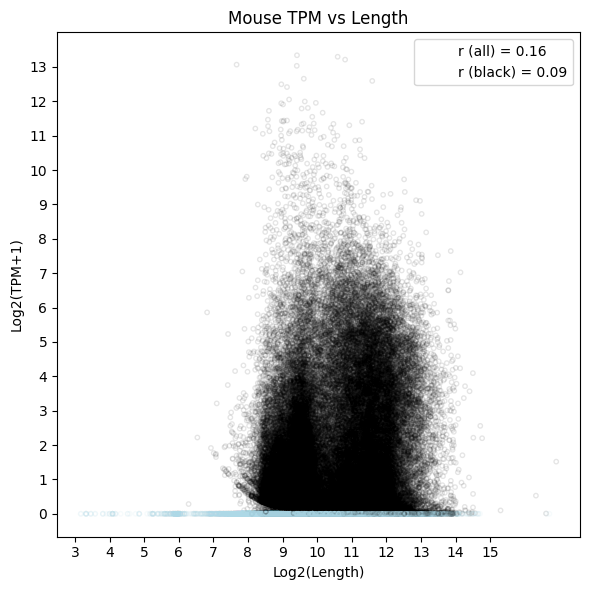

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))

x_data = np.log2(mouse_abundance['length'])
y_data = np.log2(mouse_abundance['tpm'] + 1)

colors = ['black' if y > np.percentile(y_data,25) else 'lightblue' for y in y_data]

ax.scatter(x_data, y_data, facecolors='none', edgecolors=colors, alpha=0.1, s=10)
ax.set_xlabel('Log2(Length)')
ax.set_ylabel('Log2(TPM+1)')

ax.set_xticks(np.arange(int(min(x_data)), int(max(x_data))))
ax.set_yticks(np.arange(int(min(y_data)), int(max(y_data))+1))

# Pearson's coefficient for all
r_tpm_all, _ = pearsonr(x_data, y_data)

# Subset data where y_data <= 25% percentile
x_data_black = [x for x, y in zip(x_data, y_data) if y > np.percentile(y_data,25)]
y_data_black = [y for y in y_data if y > np.percentile(y_data,25)]

# Pearson's coefficient for subset
r_tpm_black, _ = pearsonr(x_data_black, y_data_black)

ax.set_title(f'Mouse TPM vs Length')
line1, = ax.plot([], [], ' ', label=f'r (all) = {r_tpm_all:.2f}')
line2, = ax.plot([], [], ' ', label=f'r (black) = {r_tpm_black:.2f}')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

#plt.savefig('mouse_abundance_tpm_scatter.png', dpi=300, bbox_inches='tight')

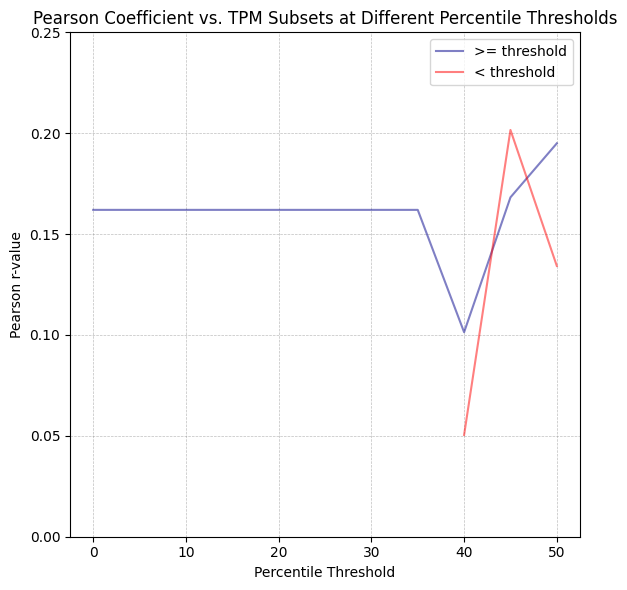

In [8]:
x_data = np.log2(mouse_abundance['length'])
y_data = np.log2(mouse_abundance['tpm'] + 1)

# Initialize lists to store r-values
r_values_above_threshold = []
r_values_below_threshold = []

# Define percentile thresholds instead of fixed CPM thresholds
percentile_thresholds = np.arange(0, 51, 5)  # Thresholds from 0th to 50th percentile, in steps of 5%

for percentile in percentile_thresholds:
    threshold = np.percentile(y_data, percentile)

    # Data above the percentile threshold
    x_data_above = x_data[y_data >= threshold]
    y_data_above = y_data[y_data >= threshold]

    # Pearson's coefficient for the subset above the threshold
    if len(x_data_above) > 0 and len(y_data_above) > 0:
        r_value_above, _ = pearsonr(x_data_above, y_data_above)
    else:
        r_value_above = np.nan

    r_values_above_threshold.append(r_value_above)
    
    # Data below the percentile threshold
    x_data_below = x_data[y_data < threshold]
    y_data_below = y_data[y_data < threshold]

    # Pearson's coefficient for the subset below the threshold
    if len(x_data_below) > 0 and len(y_data_below) > 0:
        r_value_below, _ = pearsonr(x_data_below, y_data_below)
    else:
        r_value_below = np.nan

    r_values_below_threshold.append(r_value_below)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile_thresholds, r_values_above_threshold, color='darkblue', alpha=0.5, label='>= threshold')
ax.plot(percentile_thresholds, r_values_below_threshold, color='red', alpha=0.5, label='< threshold')

ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel('Percentile Threshold')
ax.set_ylabel('Pearson r-value')

all_r_values = r_values_above_threshold + r_values_below_threshold
ax.set_yticks(np.arange(np.floor(np.nanmin(all_r_values) * 10) / 10,
                        np.ceil(np.nanmax(all_r_values) * 10) / 10,
                        step=0.05))
ax.set_title('Pearson Coefficient vs. TPM Subsets at Different Percentile Thresholds')
ax.legend()
plt.tight_layout()
plt.show()

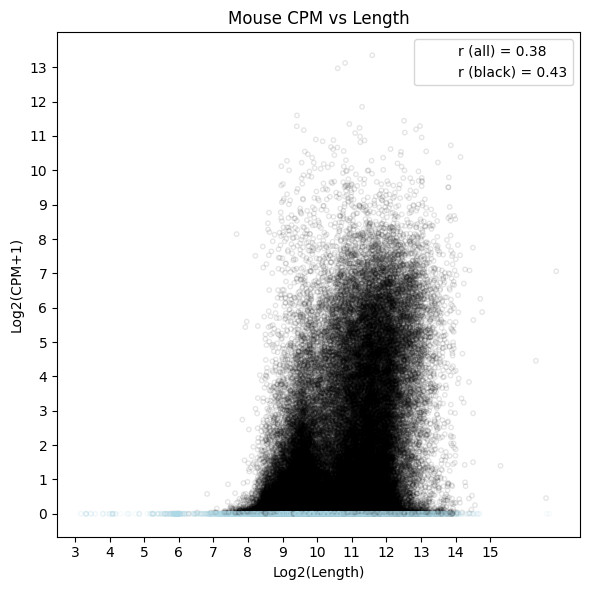

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))

x_data = np.log2(mouse_abundance['length'])
y_data = np.log2(mouse_abundance['cpm'] + 1)

colors = ['black' if y > np.percentile(y_data,25) else 'lightblue' for y in y_data]

ax.scatter(x_data, y_data, facecolors='none', edgecolors=colors, alpha=0.1, s=10)
ax.set_xlabel('Log2(Length)')
ax.set_ylabel('Log2(CPM+1)')

ax.set_xticks(np.arange(int(min(x_data)), int(max(x_data))))
ax.set_yticks(np.arange(int(min(y_data)), int(max(y_data))+1))

# Pearson's coefficient for all
r_cpm_all, _ = pearsonr(x_data, y_data)

# Subset data where y_data <= 25% percentile
x_data_black = [x for x, y in zip(x_data, y_data) if y > np.percentile(y_data,25)]
y_data_black = [y for y in y_data if y > np.percentile(y_data,25)]

# Pearson's coefficient for subset
r_cpm_black, _ = pearsonr(x_data_black, y_data_black)

ax.set_title(f'Mouse CPM vs Length')
line1, = ax.plot([], [], ' ', label=f'r (all) = {r_cpm_all:.2f}')
line2, = ax.plot([], [], ' ', label=f'r (black) = {r_cpm_black:.2f}')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

#plt.savefig('mouse_abundance_cpm_scatter.png', dpi=300, bbox_inches='tight')

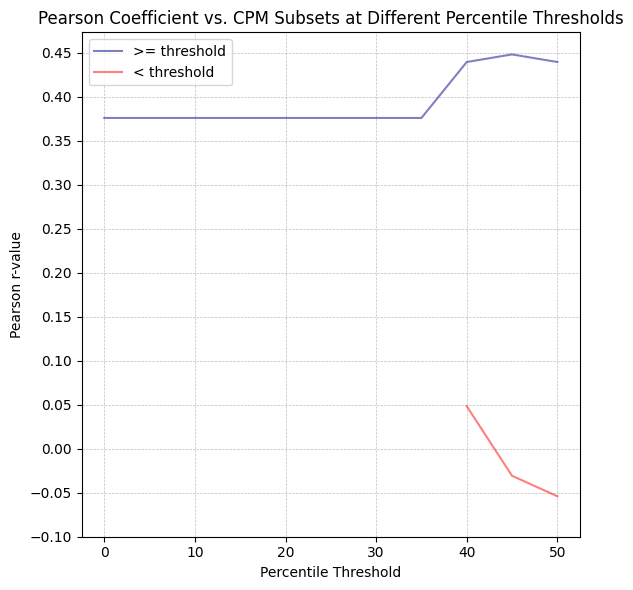

In [10]:
x_data = np.log2(mouse_abundance['length'])
y_data = np.log2(mouse_abundance['cpm'] + 1)

# Initialize lists to store r-values
r_values_above_threshold = []
r_values_below_threshold = []

# Define percentile thresholds instead of fixed CPM thresholds
percentile_thresholds = np.arange(0, 51, 5)  # Thresholds from 0th to 50th percentile, in steps of 5%

for percentile in percentile_thresholds:
    threshold = np.percentile(y_data, percentile)

    # Data above the percentile threshold
    x_data_above = x_data[y_data >= threshold]
    y_data_above = y_data[y_data >= threshold]

    # Pearson's coefficient for the subset above the threshold
    if len(x_data_above) > 0 and len(y_data_above) > 0:
        r_value_above, _ = pearsonr(x_data_above, y_data_above)
    else:
        r_value_above = np.nan

    r_values_above_threshold.append(r_value_above)
    
    # Data below the percentile threshold
    x_data_below = x_data[y_data < threshold]
    y_data_below = y_data[y_data < threshold]

    # Pearson's coefficient for the subset below the threshold
    if len(x_data_below) > 0 and len(y_data_below) > 0:
        r_value_below, _ = pearsonr(x_data_below, y_data_below)
    else:
        r_value_below = np.nan

    r_values_below_threshold.append(r_value_below)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile_thresholds, r_values_above_threshold, color='darkblue', alpha=0.5, label='>= threshold')
ax.plot(percentile_thresholds, r_values_below_threshold, color='red', alpha=0.5, label='< threshold')

ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel('Percentile Threshold')
ax.set_ylabel('Pearson r-value')

all_r_values = r_values_above_threshold + r_values_below_threshold
ax.set_yticks(np.arange(np.floor(np.nanmin(all_r_values) * 10) / 10,
                        np.ceil(np.nanmax(all_r_values) * 10) / 10,
                        step=0.05))
ax.set_title('Pearson Coefficient vs. CPM Subsets at Different Percentile Thresholds')
ax.legend()
plt.tight_layout()
plt.show()

In [11]:
mouse_abundance.dropna(subset=["length"], inplace=True)
bins, bin_edges = pd.qcut(np.log2(mouse_abundance["length"]), n_bins, labels=False, retbins=True)

bin_labels = []
for i in range(len(bin_edges)-1):
    bin_label = f"{round(bin_edges[i])}-{round(bin_edges[i+1])}bp"
    bin_labels.append(bin_label)
    print(f"Bin {i}: {bin_label}")

mouse_abundance["BinnedLength"] = bins

Bin 0: 3-9bp
Bin 1: 9-9bp
Bin 2: 9-9bp
Bin 3: 9-10bp
Bin 4: 10-10bp
Bin 5: 10-11bp
Bin 6: 11-11bp
Bin 7: 11-12bp
Bin 8: 12-12bp
Bin 9: 12-17bp


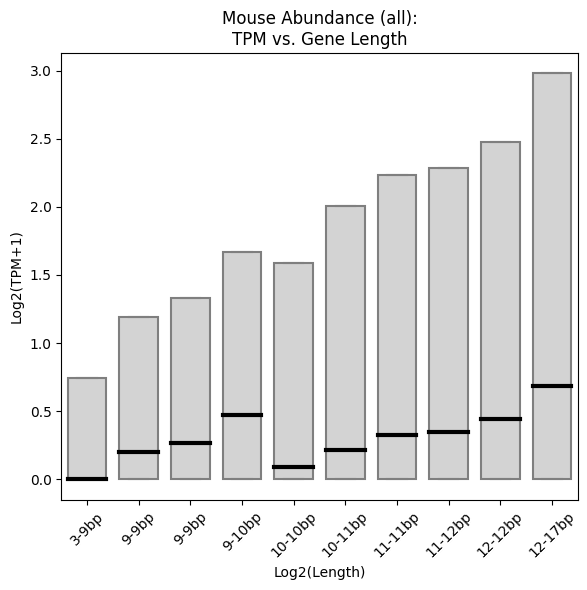

In [12]:
plt.figure(figsize=(6,6))

ax = sns.boxplot(data=mouse_abundance, x="BinnedLength", y=np.log2(mouse_abundance['tpm']+1), 
                 showfliers=False, whis=0,
                 width=0.75, 
                 color='lightgray', 
                 medianprops=dict(color='black', linewidth=3))

plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45)
plt.xlabel("Log2(Length)")
plt.ylabel("Log2(TPM+1)")
plt.title("Mouse Abundance (all):\nTPM vs. Gene Length")
plt.tight_layout()
plt.show()

#plt.savefig('mouse_abundance_tmp_boxplot.png', dpi=300, bbox_inches='tight')

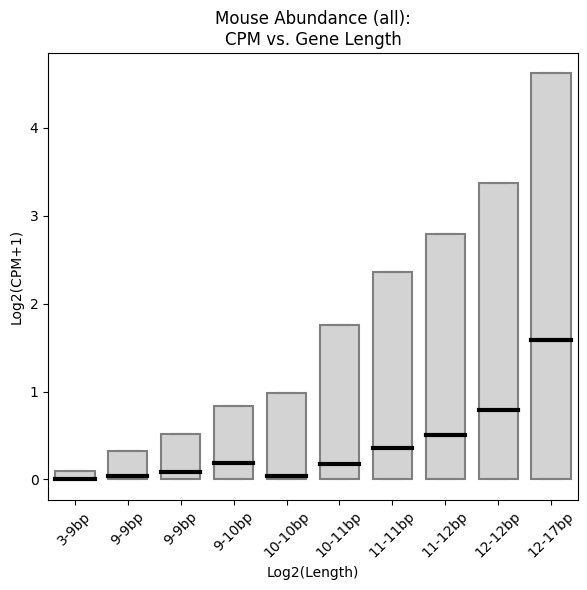

In [13]:
plt.figure(figsize=(6,6))

ax = sns.boxplot(data=mouse_abundance, x="BinnedLength", y=np.log2(mouse_abundance['cpm']+1), 
                 showfliers=False, whis=0,
                 width=0.75, 
                 color='lightgray', 
                 medianprops=dict(color='black', linewidth=3))

plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45)
plt.xlabel("Log2(Length)")
plt.ylabel("Log2(CPM+1)")
plt.title("Mouse Abundance (all):\nCPM vs. Gene Length")
plt.tight_layout()
plt.show()

#plt.savefig('mouse_abundance_cpm_boxplot.png', dpi=300, bbox_inches='tight')

In [14]:
mask = mouse_abundance["tpm"].quantile(0.25)
filtered = mouse_abundance[mouse_abundance["tpm"] > mask].drop(columns=["BinnedLength"])

In [15]:
filtered_copy = filtered.dropna(subset=["length"]).copy()
bins, bin_edges = pd.qcut(np.log2(filtered_copy["length"]), n_bins, labels=False, retbins=True)

bin_labels = []
for i in range(len(bin_edges)-1):
    bin_label = f"{round(bin_edges[i])}-{round(bin_edges[i+1])}bp"
    bin_labels.append(bin_label)
    print(f"Bin {i}: {bin_label}")

filtered_copy.loc[:, "BinnedLength"] = bins

Bin 0: 6-9bp
Bin 1: 9-9bp
Bin 2: 9-10bp
Bin 3: 10-10bp
Bin 4: 10-11bp
Bin 5: 11-11bp
Bin 6: 11-11bp
Bin 7: 11-12bp
Bin 8: 12-12bp
Bin 9: 12-17bp


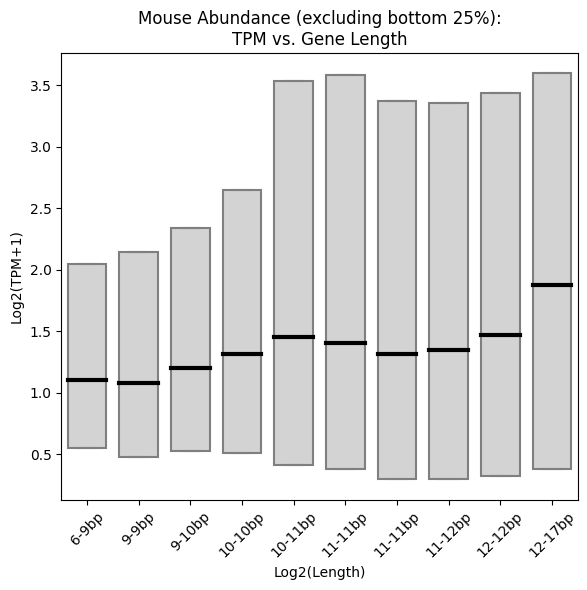

In [16]:
# Plotting without the bottom 25% genes
plt.figure(figsize=(6, 6))
ax = sns.boxplot(data=filtered_copy, x="BinnedLength", y=np.log2(filtered_copy['tpm']+1), 
                 showfliers=False, whis=0, width=0.75, color='lightgray', 
                 medianprops=dict(color='black', linewidth=3))
plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45)
plt.xlabel("Log2(Length)")
plt.ylabel("Log2(TPM+1)")
plt.title("Mouse Abundance (excluding bottom 25%):\nTPM vs. Gene Length")

plt.tight_layout()
plt.show()

In [17]:
mask = mouse_abundance["cpm"].quantile(0.25)
filtered = mouse_abundance[mouse_abundance["cpm"] > mask].drop(columns=["BinnedLength"])

In [18]:
filtered_copy = filtered.dropna(subset=["length"]).copy()
bins, bin_edges = pd.qcut(np.log2(filtered_copy["length"]), n_bins, labels=False, retbins=True)

bin_labels = []
for i in range(len(bin_edges)-1):
    bin_label = f"{round(bin_edges[i])}-{round(bin_edges[i+1])}bp"
    bin_labels.append(bin_label)
    print(f"Bin {i}: {bin_label}")

filtered_copy.loc[:, "BinnedLength"] = bins

Bin 0: 6-9bp
Bin 1: 9-9bp
Bin 2: 9-10bp
Bin 3: 10-10bp
Bin 4: 10-11bp
Bin 5: 11-11bp
Bin 6: 11-11bp
Bin 7: 11-12bp
Bin 8: 12-12bp
Bin 9: 12-17bp


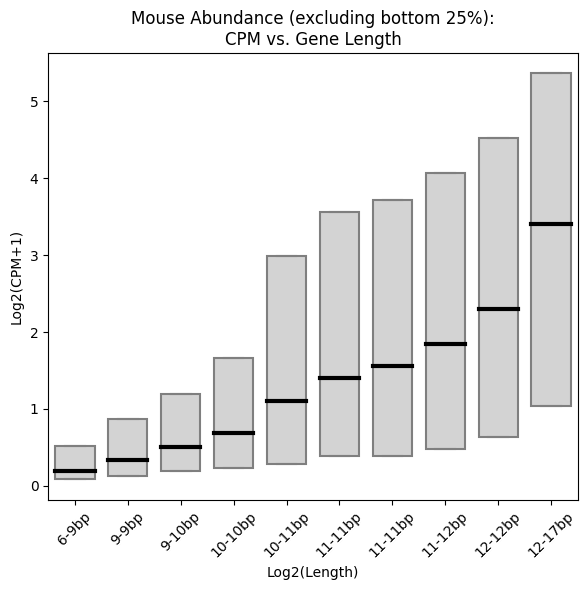

In [19]:
# Plotting without the bottom 25% genes
plt.figure(figsize=(6, 6))
ax = sns.boxplot(data=filtered_copy, x="BinnedLength", y=np.log2(filtered_copy['cpm']+1), 
                 showfliers=False, whis=0, width=0.75, color='lightgray', 
                 medianprops=dict(color='black', linewidth=3))
plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45)
plt.xlabel("Log2(Length)")
plt.ylabel("Log2(CPM+1)")
plt.title("Mouse Abundance (excluding bottom 25%):\nCPM vs. Gene Length")

plt.tight_layout()
plt.show()

### Human abundance

Load and inspect the data

In [20]:
!ls ./bulk/human/processed_SRR710092/quant_unfiltered

abundance_1.tsv		       matrix.abundance.tpm.mtx
abundance.gene_1.tsv	       matrix.efflens.mtx
genes.txt		       matrix.fld.tsv
matrix.abundance.gene.mtx      transcript_lengths.txt
matrix.abundance.gene.tpm.mtx  transcripts.txt
matrix.abundance.mtx


In [21]:
dir = "/bulk/mouse/processed_SRR7725699/quant_unfiltered/"

In [23]:
human_abundance = pd.read_csv(dir+"abundance_1.tsv", sep='\t')
human_abundance

,target_id,length,eff_length,est_counts,tpm
0,ENSMUST00000061280.17,5232,5064.4400,1099.21000,10.402000
1,ENSMUST00000182823.2,2659,2491.4400,80.76080,1.553520
2,ENSMUST00000183204.2,3986,3818.4400,67.12650,0.842510
3,ENSMUST00000182892.8,4207,4039.4400,220.72600,2.618780
4,ENSMUST00000182675.8,1153,985.4380,168.04200,8.172510
...,...,...,...,...,...
103099,ENSMUST00000179715.2,366,198.6580,0.00000,0.000000
103100,ENSMUST00000115924.3,1910,1742.4400,1.37161,0.037726
103101,ENSMUST00000178343.2,4060,3892.4400,5007.80000,61.658400
103102,ENSMUST00000179505.8,2373,2205.4400,5656.50000,122.919000


Compute CPM values

In [24]:
total_counts = human_abundance['est_counts'].sum()
human_abundance['cpm'] = human_abundance['est_counts'] / total_counts * 1e6
human_abundance

,target_id,length,eff_length,est_counts,tpm,cpm
0,ENSMUST00000061280.17,5232,5064.4400,1099.21000,10.402000,30.467610
1,ENSMUST00000182823.2,2659,2491.4400,80.76080,1.553520,2.238506
2,ENSMUST00000183204.2,3986,3818.4400,67.12650,0.842510,1.860594
3,ENSMUST00000182892.8,4207,4039.4400,220.72600,2.618780,6.118024
4,ENSMUST00000182675.8,1153,985.4380,168.04200,8.172510,4.657743
...,...,...,...,...,...,...
103099,ENSMUST00000179715.2,366,198.6580,0.00000,0.000000,0.000000
103100,ENSMUST00000115924.3,1910,1742.4400,1.37161,0.037726,0.038018
103101,ENSMUST00000178343.2,4060,3892.4400,5007.80000,61.658400,138.804867
103102,ENSMUST00000179505.8,2373,2205.4400,5656.50000,122.919000,156.785360


Plot TPM vs Length and CPM vs Length

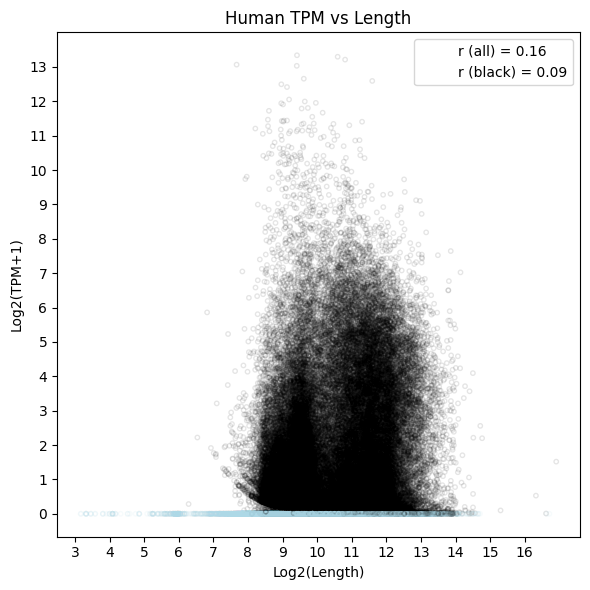

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))

x_data = np.log2(human_abundance['length'])
y_data = np.log2(human_abundance['tpm'] + 1)

colors = ['black' if y > np.percentile(y_data,25) else 'lightblue' for y in y_data]

ax.scatter(x_data, y_data, facecolors='none', edgecolors=colors, alpha=0.1, s=10)
ax.set_xlabel('Log2(Length)')
ax.set_ylabel('Log2(TPM+1)')

ax.set_xticks(np.arange(int(min(x_data)), int(max(x_data))+1))
ax.set_yticks(np.arange(int(min(y_data)), int(max(y_data))+1))

# Pearson's coefficient for all
r_tpm_all, _ = pearsonr(x_data, y_data)

# Subset data where y_data <= 25% percentile
x_data_black = [x for x, y in zip(x_data, y_data) if y > np.percentile(y_data,25)]
y_data_black = [y for y in y_data if y > np.percentile(y_data,25)]

# Pearson's coefficient for subset
r_tpm_black, _ = pearsonr(x_data_black, y_data_black)

ax.set_title(f'Human TPM vs Length')
line1, = ax.plot([], [], ' ', label=f'r (all) = {r_tpm_all:.2f}')
line2, = ax.plot([], [], ' ', label=f'r (black) = {r_tpm_black:.2f}')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

#plt.savefig('human_abundance_tpm_scatter.png', dpi=300, bbox_inches='tight')

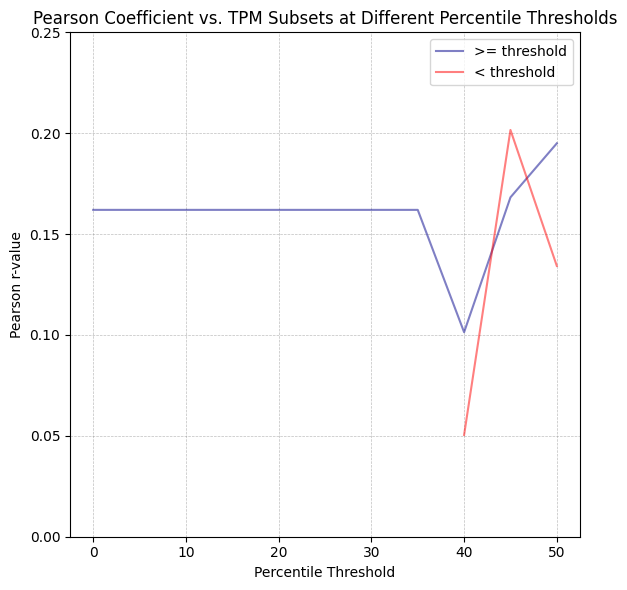

In [26]:
x_data = np.log2(mouse_abundance['length'])
y_data = np.log2(mouse_abundance['tpm'] + 1)

# Initialize lists to store r-values
r_values_above_threshold = []
r_values_below_threshold = []

# Define percentile thresholds instead of fixed CPM thresholds
percentile_thresholds = np.arange(0, 51, 5)  # Thresholds from 0th to 50th percentile, in steps of 5%

for percentile in percentile_thresholds:
    threshold = np.percentile(y_data, percentile)

    # Data above the percentile threshold
    x_data_above = x_data[y_data >= threshold]
    y_data_above = y_data[y_data >= threshold]

    # Pearson's coefficient for the subset above the threshold
    if len(x_data_above) > 0 and len(y_data_above) > 0:
        r_value_above, _ = pearsonr(x_data_above, y_data_above)
    else:
        r_value_above = np.nan

    r_values_above_threshold.append(r_value_above)
    
    # Data below the percentile threshold
    x_data_below = x_data[y_data < threshold]
    y_data_below = y_data[y_data < threshold]

    # Pearson's coefficient for the subset below the threshold
    if len(x_data_below) > 0 and len(y_data_below) > 0:
        r_value_below, _ = pearsonr(x_data_below, y_data_below)
    else:
        r_value_below = np.nan

    r_values_below_threshold.append(r_value_below)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile_thresholds, r_values_above_threshold, color='darkblue', alpha=0.5, label='>= threshold')
ax.plot(percentile_thresholds, r_values_below_threshold, color='red', alpha=0.5, label='< threshold')

ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel('Percentile Threshold')
ax.set_ylabel('Pearson r-value')

all_r_values = r_values_above_threshold + r_values_below_threshold
ax.set_yticks(np.arange(np.floor(np.nanmin(all_r_values) * 10) / 10,
                        np.ceil(np.nanmax(all_r_values) * 10) / 10,
                        step=0.05))
ax.set_title('Pearson Coefficient vs. TPM Subsets at Different Percentile Thresholds')
ax.legend()
plt.tight_layout()
plt.show()

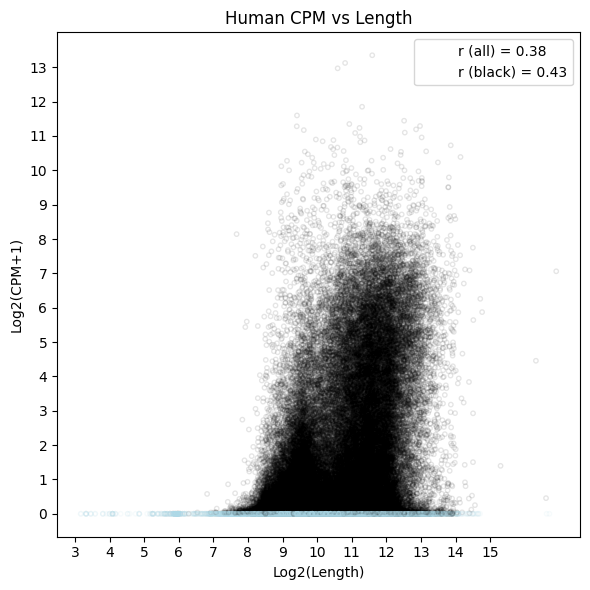

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))

x_data = np.log2(human_abundance['length'])
y_data = np.log2(human_abundance['cpm'] + 1)

colors = ['black' if y > np.percentile(y_data,25) else 'lightblue' for y in y_data]

ax.scatter(x_data, y_data, facecolors='none', edgecolors=colors, alpha=0.1, s=10)
ax.set_xlabel('Log2(Length)')
ax.set_ylabel('Log2(CPM+1)')

ax.set_xticks(np.arange(int(min(x_data)), int(max(x_data))))
ax.set_yticks(np.arange(int(min(y_data)), int(max(y_data))+1))

# Pearson's coefficient for all
r_cpm_all, _ = pearsonr(x_data, y_data)

# Subset data where y_data <= 25% percentile
x_data_black = [x for x, y in zip(x_data, y_data) if y > np.percentile(y_data,25)]
y_data_black = [y for y in y_data if y > np.percentile(y_data,25)]

# Pearson's coefficient for subset
r_cpm_black, _ = pearsonr(x_data_black, y_data_black)

ax.set_title(f'Human CPM vs Length')
line1, = ax.plot([], [], ' ', label=f'r (all) = {r_cpm_all:.2f}')
line2, = ax.plot([], [], ' ', label=f'r (black) = {r_cpm_black:.2f}')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

#plt.savefig('human_abundance_cpm_scatter.png', dpi=300, bbox_inches='tight')

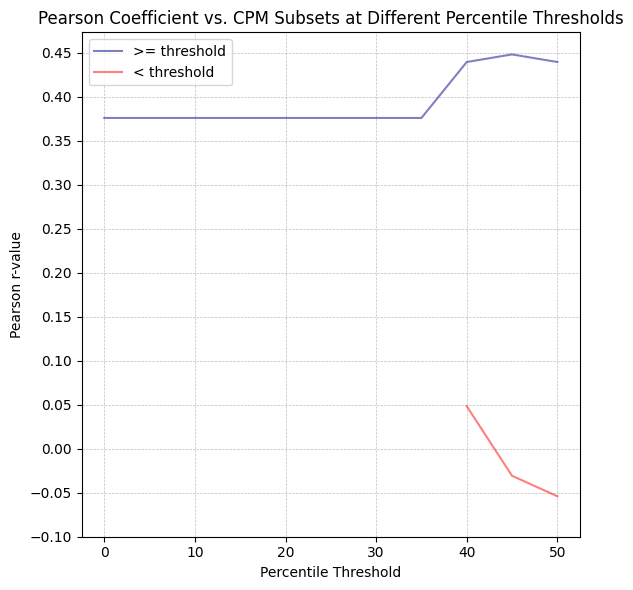

In [28]:
x_data = np.log2(mouse_abundance['length'])
y_data = np.log2(mouse_abundance['cpm'] + 1)

# Initialize lists to store r-values
r_values_above_threshold = []
r_values_below_threshold = []

# Define percentile thresholds instead of fixed CPM thresholds
percentile_thresholds = np.arange(0, 51, 5)  # Thresholds from 0th to 50th percentile, in steps of 5%

for percentile in percentile_thresholds:
    threshold = np.percentile(y_data, percentile)

    # Data above the percentile threshold
    x_data_above = x_data[y_data >= threshold]
    y_data_above = y_data[y_data >= threshold]

    # Pearson's coefficient for the subset above the threshold
    if len(x_data_above) > 0 and len(y_data_above) > 0:
        r_value_above, _ = pearsonr(x_data_above, y_data_above)
    else:
        r_value_above = np.nan

    r_values_above_threshold.append(r_value_above)
    
    # Data below the percentile threshold
    x_data_below = x_data[y_data < threshold]
    y_data_below = y_data[y_data < threshold]

    # Pearson's coefficient for the subset below the threshold
    if len(x_data_below) > 0 and len(y_data_below) > 0:
        r_value_below, _ = pearsonr(x_data_below, y_data_below)
    else:
        r_value_below = np.nan

    r_values_below_threshold.append(r_value_below)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile_thresholds, r_values_above_threshold, color='darkblue', alpha=0.5, label='>= threshold')
ax.plot(percentile_thresholds, r_values_below_threshold, color='red', alpha=0.5, label='< threshold')

ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel('Percentile Threshold')
ax.set_ylabel('Pearson r-value')

all_r_values = r_values_above_threshold + r_values_below_threshold
ax.set_yticks(np.arange(np.floor(np.nanmin(all_r_values) * 10) / 10,
                        np.ceil(np.nanmax(all_r_values) * 10) / 10,
                        step=0.05))
ax.set_title('Pearson Coefficient vs. CPM Subsets at Different Percentile Thresholds')
ax.legend()
plt.tight_layout()
plt.show()

In [29]:
human_abundance.dropna(subset=["length"], inplace=True)
bins, bin_edges = pd.qcut(np.log2(human_abundance["length"]), n_bins, labels=False, retbins=True)

bin_labels = []
for i in range(len(bin_edges)-1):
    bin_label = f"{round(bin_edges[i])}-{round(bin_edges[i+1])}bp"
    bin_labels.append(bin_label)
    print(f"Bin {i}: {bin_label}")

human_abundance["BinnedLength"] = bins

Bin 0: 3-9bp
Bin 1: 9-9bp
Bin 2: 9-9bp
Bin 3: 9-10bp
Bin 4: 10-10bp
Bin 5: 10-11bp
Bin 6: 11-11bp
Bin 7: 11-12bp
Bin 8: 12-12bp
Bin 9: 12-17bp


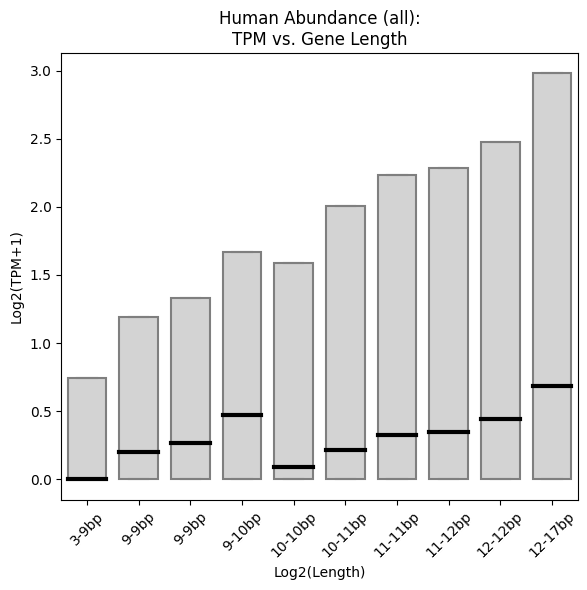

In [30]:
plt.figure(figsize=(6,6))

ax = sns.boxplot(data=human_abundance, x="BinnedLength", y=np.log2(human_abundance['tpm']+1), 
                 showfliers=False, whis=0,
                 width=0.75, 
                 color='lightgray', 
                 medianprops=dict(color='black', linewidth=3))

plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45)
plt.xlabel("Log2(Length)")
plt.ylabel("Log2(TPM+1)")
plt.title("Human Abundance (all):\nTPM vs. Gene Length")
plt.tight_layout()
plt.show()

#plt.savefig('human_abundance_tpm_boxplot.png', dpi=300, bbox_inches='tight')

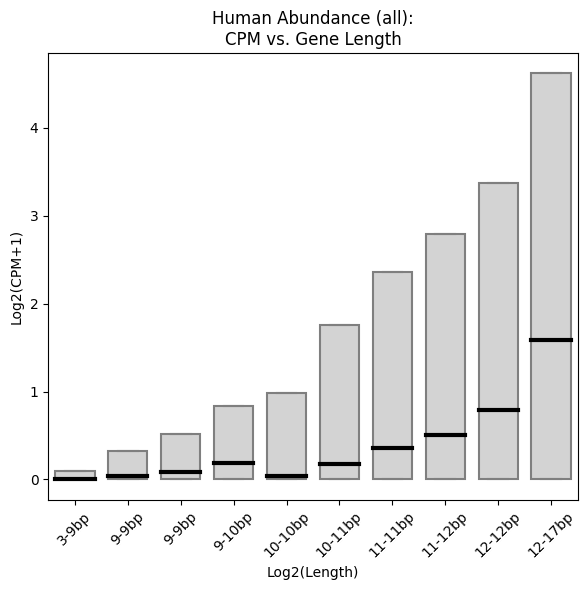

In [31]:
plt.figure(figsize=(6,6))

ax = sns.boxplot(data=human_abundance, x="BinnedLength", y=np.log2(human_abundance['cpm']+1), 
                 showfliers=False, whis=0,
                 width=0.75, 
                 color='lightgray', 
                 medianprops=dict(color='black', linewidth=3))

plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45)
plt.xlabel("Log2(Length)")
plt.ylabel("Log2(CPM+1)")
plt.title("Human Abundance (all):\nCPM vs. Gene Length")
plt.tight_layout()
plt.show()

#plt.savefig('human_abundance_cpm_boxplot.png', dpi=300, bbox_inches='tight')

In [32]:
mask = human_abundance["tpm"].quantile(0.25)
filtered = human_abundance[human_abundance["tpm"] > mask].drop(columns=["BinnedLength"])

In [33]:
filtered_copy = filtered.dropna(subset=["length"]).copy()
bins, bin_edges = pd.qcut(np.log2(filtered_copy["length"]), n_bins, labels=False, retbins=True)

bin_labels = []
for i in range(len(bin_edges)-1):
    bin_label = f"{round(bin_edges[i])}-{round(bin_edges[i+1])}bp"
    bin_labels.append(bin_label)
    print(f"Bin {i}: {bin_label}")

filtered_copy.loc[:, "BinnedLength"] = bins

Bin 0: 6-9bp
Bin 1: 9-9bp
Bin 2: 9-10bp
Bin 3: 10-10bp
Bin 4: 10-11bp
Bin 5: 11-11bp
Bin 6: 11-11bp
Bin 7: 11-12bp
Bin 8: 12-12bp
Bin 9: 12-17bp


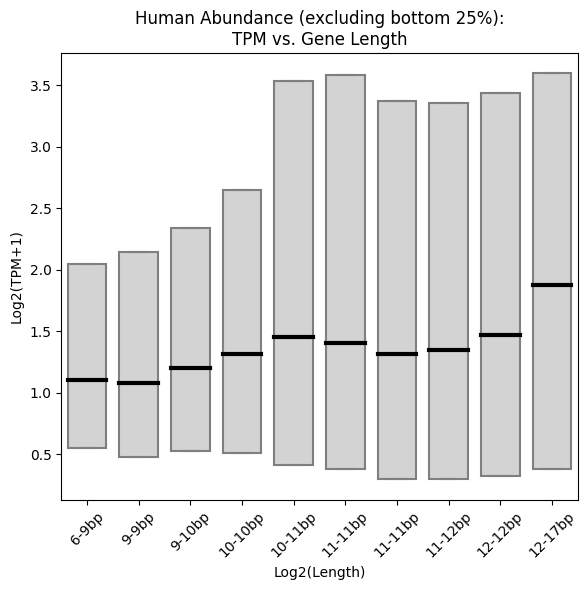

In [34]:
# Plotting without the bottom 25% genes
plt.figure(figsize=(6, 6))
ax = sns.boxplot(data=filtered_copy, x="BinnedLength", y=np.log2(filtered_copy['tpm']+1), 
                 showfliers=False, whis=0, width=0.75, color='lightgray', 
                 medianprops=dict(color='black', linewidth=3))
plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45)
plt.xlabel("Log2(Length)")
plt.ylabel("Log2(TPM+1)")
plt.title("Human Abundance (excluding bottom 25%):\nTPM vs. Gene Length")

plt.tight_layout()
plt.show()

In [35]:
mask = human_abundance["cpm"].quantile(0.25)
filtered = human_abundance[human_abundance["cpm"] > mask].drop(columns=["BinnedLength"])

In [36]:
filtered_copy = filtered.dropna(subset=["length"]).copy()
bins, bin_edges = pd.qcut(np.log2(filtered_copy["length"]), n_bins, labels=False, retbins=True)

bin_labels = []
for i in range(len(bin_edges)-1):
    bin_label = f"{round(bin_edges[i])}-{round(bin_edges[i+1])}bp"
    bin_labels.append(bin_label)
    print(f"Bin {i}: {bin_label}")

filtered_copy.loc[:, "BinnedLength"] = bins

Bin 0: 6-9bp
Bin 1: 9-9bp
Bin 2: 9-10bp
Bin 3: 10-10bp
Bin 4: 10-11bp
Bin 5: 11-11bp
Bin 6: 11-11bp
Bin 7: 11-12bp
Bin 8: 12-12bp
Bin 9: 12-17bp


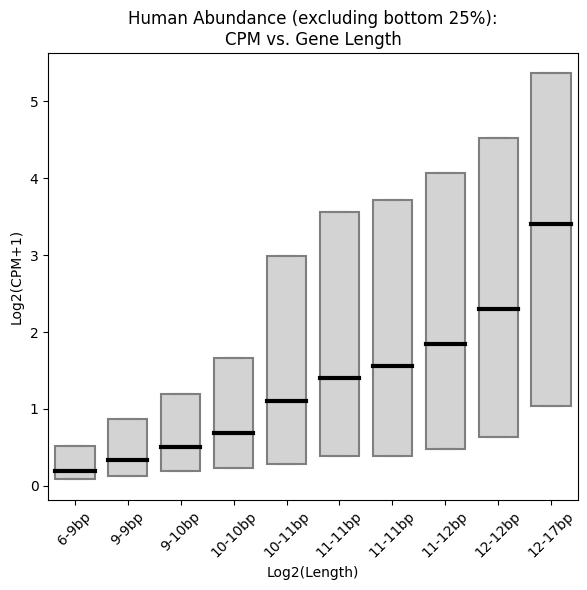

In [37]:
# Plotting without the bottom 25% genes
plt.figure(figsize=(6, 6))
ax = sns.boxplot(data=filtered_copy, x="BinnedLength", y=np.log2(filtered_copy['cpm']+1), 
                 showfliers=False, whis=0, width=0.75, color='lightgray', 
                 medianprops=dict(color='black', linewidth=3))
plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, rotation=45)
plt.xlabel("Log2(Length)")
plt.ylabel("Log2(CPM+1)")
plt.title("Human Abundance (excluding bottom 25%):\nCPM vs. Gene Length")

plt.tight_layout()
plt.show()